In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report

# Define dataset paths
test_csv_path = r"C:\Black Book Project\HAM 10000\HAM10000_split\test_color_features.csv"
valid_csv_path = r"C:\Black Book Project\HAM 10000\HAM10000_split\valid_color_features.csv"

# Load datasets
df_test = pd.read_csv(test_csv_path)
df_valid = pd.read_csv(valid_csv_path)

# Drop image name column if present
df_test.drop(columns=['Image_Name'], errors='ignore', inplace=True)
df_valid.drop(columns=['Image_Name'], errors='ignore', inplace=True)

# Separate features (X) and target (y)
X_test, y_test = df_test.drop(columns=['Label']).values, df_test['Label'].values
X_valid, y_valid = df_valid.drop(columns=['Label']).values, df_valid['Label'].values

# Encode labels
label_encoder = LabelEncoder()
y_test = label_encoder.fit_transform(y_test)
y_valid = label_encoder.transform(y_valid)

num_classes = len(label_encoder.classes_)

# Normalize features
scaler = StandardScaler()
X_test = scaler.fit_transform(X_test)
X_valid = scaler.transform(X_valid)

# Convert to PyTorch tensors
X_test, y_test = torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long)
X_valid, y_valid = torch.tensor(X_valid, dtype=torch.float32), torch.tensor(y_valid, dtype=torch.long)

# Create DataLoaders
batch_size = 32
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(TensorDataset(X_valid, y_valid), batch_size=batch_size, shuffle=True)


# Define a Residual Block
class ResidualBlock(nn.Module):
    def __init__(self, input_size):
        super(ResidualBlock, self).__init__()
        self.fc1 = nn.Linear(input_size, input_size)
        self.bn1 = nn.BatchNorm1d(input_size)
        self.fc2 = nn.Linear(input_size, input_size)
        self.bn2 = nn.BatchNorm1d(input_size)
        self.activation = nn.LeakyReLU(0.1)  # Better activation function
        self.dropout = nn.Dropout(0.4)  # Higher dropout to reduce overfitting

    def forward(self, x):
        residual = x
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.activation(out)
        out = self.dropout(out)

        out = self.fc2(out)
        out = self.bn2(out)

        out += residual  # Skip connection
        out = self.activation(out)
        return out


# Define MLP-ResNet Model
class MLPResNet(nn.Module):
    def __init__(self, input_size, num_classes, num_blocks=10):  # 10 residual blocks
        super(MLPResNet, self).__init__()
        self.fc_initial = nn.Linear(input_size, 1024)  # Increased neurons for better learning
        self.bn_initial = nn.BatchNorm1d(1024)
        self.activation = nn.LeakyReLU(0.1)

        # Stack residual blocks
        self.residual_blocks = nn.Sequential(*[ResidualBlock(1024) for _ in range(num_blocks)])

        self.fc_final = nn.Linear(1024, num_classes)

    def forward(self, x):
        x = self.fc_initial(x)
        x = self.bn_initial(x)
        x = self.activation(x)

        x = self.residual_blocks(x)

        x = self.fc_final(x)
        return x


# Model setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_size = X_test.shape[1]
model = MLPResNet(input_size, num_classes).to(device)

# Compute class weights to handle imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(y_test.numpy()), y=y_test.numpy())
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Loss function and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)  # Using class weights
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Increased learning rate
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)  # Learning rate decay

# Training loop
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in test_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    scheduler.step()  # Adjust learning rate

    if (epoch + 1) % 10 == 0:
        avg_loss = total_loss / len(test_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss:.4f}")

print("Training complete!")


# Function to calculate accuracy
def calculate_accuracy(model, data_loader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            total += y_batch.size(0)
            correct += (predicted == y_batch).sum().item()

    return 100 * correct / total


# Function to generate classification report
def generate_classification_report(model, data_loader, label_encoder, dataset_name, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    report = classification_report(all_labels, all_preds, target_names=label_encoder.classes_, digits=2)
    print(f"\nClassification Report for {dataset_name}:\n")
    print(report)


# Evaluate Test Set
test_accuracy = calculate_accuracy(model, test_loader, device)
print(f"Test Accuracy: {test_accuracy:.2f}%")
generate_classification_report(model, test_loader, label_encoder, "Test Set", device)

# Evaluate Validation Set
valid_accuracy = calculate_accuracy(model, valid_loader, device)
print(f"Validation Accuracy: {valid_accuracy:.2f}%")
generate_classification_report(model, valid_loader, label_encoder, "Validation Set", device)


Epoch 10/100, Loss: 1.8229
Epoch 20/100, Loss: 1.5125
Epoch 30/100, Loss: 1.3970
Epoch 40/100, Loss: 1.2570
Epoch 50/100, Loss: 1.1983
Epoch 60/100, Loss: 1.2117
Epoch 70/100, Loss: 1.1110
Epoch 80/100, Loss: 1.1203
Epoch 90/100, Loss: 1.1533
Epoch 100/100, Loss: 1.1125
Training complete!
Test Accuracy: 66.05%

Classification Report for Test Set:

              precision    recall  f1-score   support

       akiec       0.52      0.72      0.60        69
         bcc       0.59      0.62      0.61        69
         bkl       0.63      0.55      0.59        69
          df       0.65      0.45      0.53        69
         mel       0.69      0.78      0.73        69
          nv       0.79      0.61      0.69        69
        vasc       0.82      0.88      0.85        69

    accuracy                           0.66       483
   macro avg       0.67      0.66      0.66       483
weighted avg       0.67      0.66      0.66       483

Validation Accuracy: 47.52%

Classification Report fo

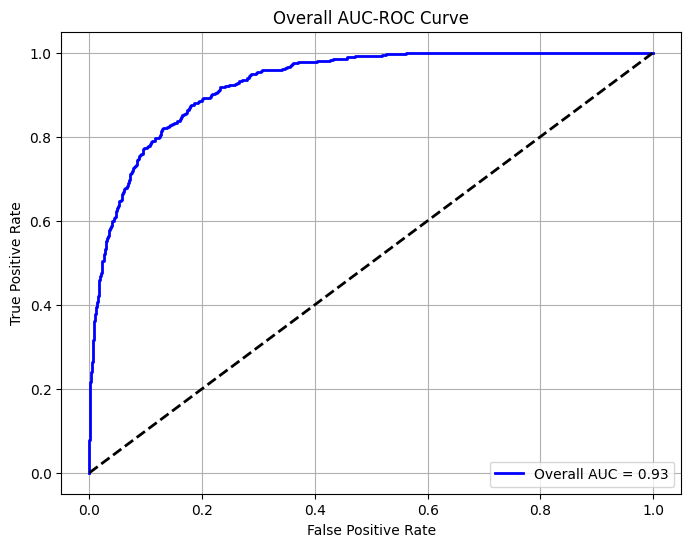

Overall AUC Score: 0.9298


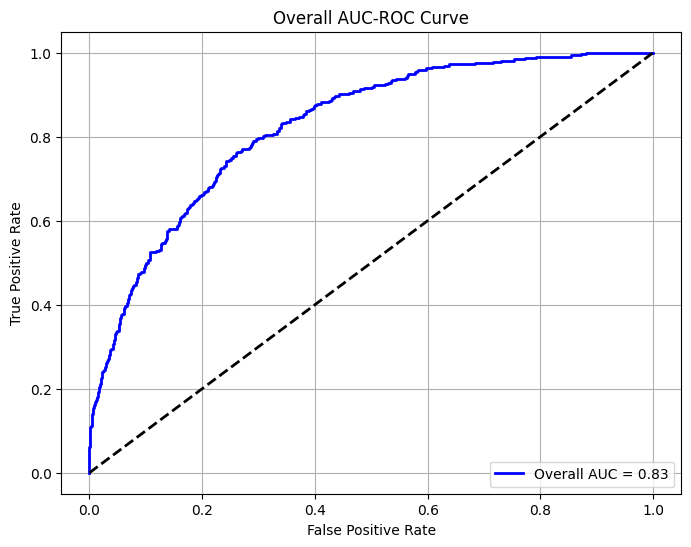

Overall AUC Score: 0.8263


In [5]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_overall_auc_roc(model, data_loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Convert labels to one-hot encoding
    all_labels = label_binarize(all_labels, classes=np.arange(num_classes))
    all_probs = np.array(all_probs)

    # Compute micro-average ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels.ravel(), all_probs.ravel())
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'Overall AUC = {roc_auc:.2f}')
    plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random guessing)
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Overall AUC-ROC Curve')
    plt.legend(loc='lower right')
    plt.grid()
    plt.show()

    print(f'Overall AUC Score: {roc_auc:.4f}')


# Plot Overall AUC-ROC Curve for Test Set
plot_overall_auc_roc(model, test_loader, device)

# Plot Overall AUC-ROC Curve for Validation Set
plot_overall_auc_roc(model, valid_loader, device)


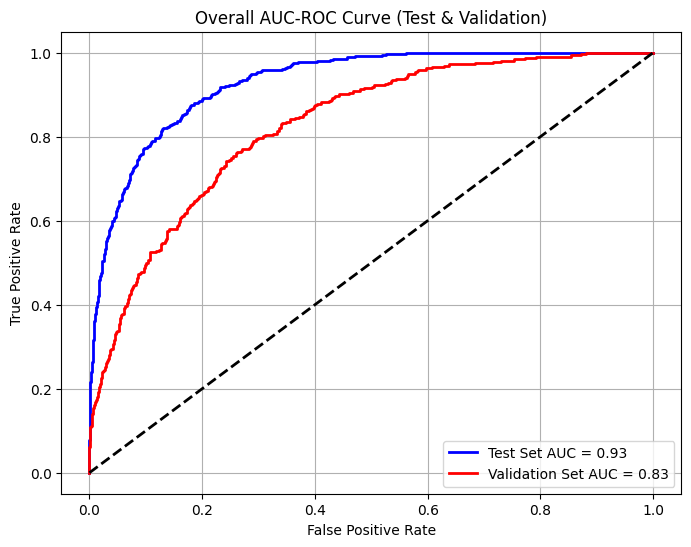

Overall Test Set AUC Score: 0.9298
Overall Validation Set AUC Score: 0.8263


In [6]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize

def get_auc_roc_values(model, data_loader, device):
    model.eval()
    all_probs = []
    all_labels = []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1)  # Convert logits to probabilities

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(y_batch.cpu().numpy())

    # Convert labels to one-hot encoding
    all_labels = label_binarize(all_labels, classes=np.arange(num_classes))
    all_probs = np.array(all_probs)

    # Compute micro-average ROC curve and AUC
    fpr, tpr, _ = roc_curve(all_labels.ravel(), all_probs.ravel())
    roc_auc = auc(fpr, tpr)

    return fpr, tpr, roc_auc

# Get AUC values for Test and Validation sets
fpr_test, tpr_test, auc_test = get_auc_roc_values(model, test_loader, device)
fpr_valid, tpr_valid, auc_valid = get_auc_roc_values(model, valid_loader, device)

# Plot AUC-ROC Curve
plt.figure(figsize=(8, 6))
plt.plot(fpr_test, tpr_test, color='blue', lw=2, label=f'Test Set AUC = {auc_test:.2f}')
plt.plot(fpr_valid, tpr_valid, color='red', lw=2, label=f'Validation Set AUC = {auc_valid:.2f}')
plt.plot([0, 1], [0, 1], 'k--', lw=2)  # Diagonal line (random guessing)

# Labels & Title
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Overall AUC-ROC Curve (Test & Validation)')
plt.legend(loc='lower right')
plt.grid()
plt.show()

# Print AUC scores
print(f'Overall Test Set AUC Score: {auc_test:.4f}')
print(f'Overall Validation Set AUC Score: {auc_valid:.4f}')


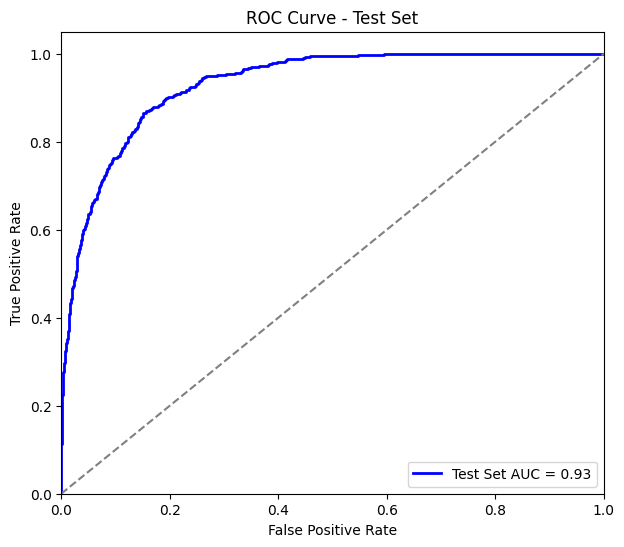

Test Set AUC Score: 0.9315


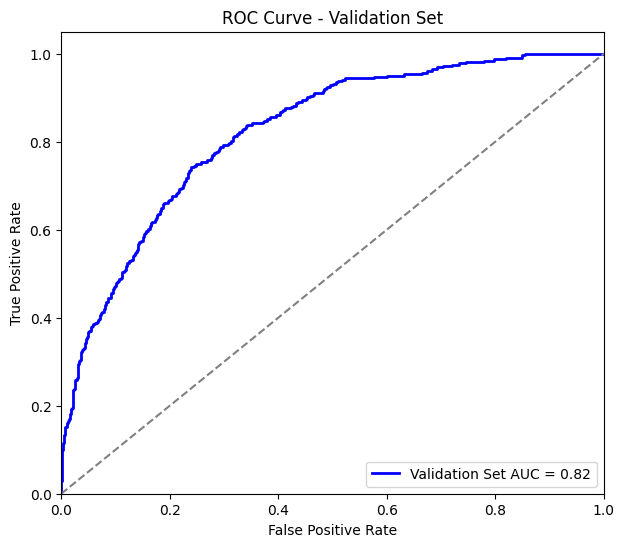

Validation Set AUC Score: 0.8238


In [15]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

def plot_auc_curve(model, data_loader, device, num_classes, dataset_name):
    model.eval()
    all_labels, all_probs = [], []

    with torch.no_grad():
        for X_batch, y_batch in data_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            outputs = model(X_batch)
            probs = torch.softmax(outputs, dim=1).cpu().numpy()
            all_probs.extend(probs)
            all_labels.extend(y_batch.cpu().numpy())

    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)

    # Binarize labels for multi-class ROC
    all_labels_bin = label_binarize(all_labels, classes=np.arange(num_classes))

    # Compute overall AUC (macro-average)
    fpr, tpr, _ = roc_curve(all_labels_bin.ravel(), all_probs.ravel())
    overall_auc = auc(fpr, tpr)

    # Plot ROC Curve
    plt.figure(figsize=(7, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'{dataset_name} AUC = {overall_auc:.2f}')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # Diagonal reference line
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {dataset_name}')
    plt.legend(loc='lower right')
    plt.show()

    print(f"{dataset_name} AUC Score: {overall_auc:.4f}")

# Call function separately for Test and Validation
plot_auc_curve(model, test_loader, device, num_classes, "Test Set")
plot_auc_curve(model, valid_loader, device, num_classes, "Validation Set")
